**<font size="4">Additional Question 2: Find if there are trends or correlation with two or more variables</font>**

**<font size="3">1. Gender, Race/Ethnicity and Geographic</font>**

In [29]:
#Step 1: Load the data (domestic vs. international students)
#For reference on how the data is separated, please see "[BU Athletics] General Data Cleaning"
import pandas as pd
q1 = pd.read_csv('Domestic_student_data.csv')

In [30]:
#Step 2: Helper Function for Calculate the Latest Cum GPA
#Step 2.1: Define the columns for cumulative GPA (latest current cumulative GPA based on class year)
cumulative_gpa_columns = [f'Semester {i} Cum GPA' for i in range(1, 13)]

#Step 2.2: Define a function to get the latest cumulative GPA (last non-null value in each row)
def get_latest_cum_gpa(row):
    for col in reversed(cumulative_gpa_columns):
        if pd.notna(row[col]):
            return row[col]
    return None

In [31]:
#Step 3.1: Apply the function to get the latest GPA for each domestic students
q1 ['Latest Cum GPA'] = q1.apply(get_latest_cum_gpa, axis=1)

#Step 3.2: Drop any rows with race/ethnicity missing
q1 = q1[q1['Student IPEDS Race Ethnicity'] != 'Missing']

#Step 3.3: Drop any rows with Student Home Admission Publication Region unknown
q1 = q1[q1['Student Home Admission Publication Region'] != 'Unknown']

In [45]:
# Count the number of students in each unique race/ethnicity
race_counts =q1['Student IPEDS Race Ethnicity'].value_counts()

# Display the results
print(race_counts)

White                                  356
Two or More Races Reported              33
Hispanic/Latino                         32
Asian                                   31
African American or Black               24
Native Hawaiian or Pacific Islander      1
Name: Student IPEDS Race Ethnicity, dtype: int64


Since there's only 1 student from Native Hawaiian or Pacific Islander, for accuracy, it would be better to exclude this data when performing ANCOVA model. Also, since the biggest race/ethnicity group is white, it would be better to set the comparison group to a more prevalent group.

In [58]:
import statsmodels.formula.api as smf

#Step 4.1: Data Preparation
data = q1[['Student Home Admission Publication Region', 
                 'Student IPEDS Race Ethnicity',
                 'Student Gender',
                'Latest Cum GPA']].dropna()

#Step 4.2: Exclude Native Hawaiian or Pacific Islander
data = data[data['Student IPEDS Race Ethnicity'] != 'Native Hawaiian or Pacific Islander']

#Step 4.3: Set 'White' as the reference group for race/ethnicity
data['Student IPEDS Race Ethnicity'] = data['Student IPEDS Race Ethnicity'].astype('category')
data['Student IPEDS Race Ethnicity'] = data['Student IPEDS Race Ethnicity'].cat.reorder_categories(
    ['White', 'Asian', 'Hispanic/Latino', 'Two or More Races Reported', 'African American or Black'], ordered=True
)

**<font size="3">1.1 Interaction Plot: Race/Ethnicity * Geographic Region</font>**

In [57]:
model_white_reference = smf.ols(
    'Q("Latest Cum GPA") ~ C(Q("Student IPEDS Race Ethnicity")) * C(Q("Student Home Admission Publication Region"))',
    data=data
).fit()

# Print the summary
print(model_white_reference.summary())

                             OLS Regression Results                            
Dep. Variable:     Q("Latest Cum GPA")   R-squared:                       0.101
Model:                             OLS   Adj. R-squared:                  0.043
Method:                  Least Squares   F-statistic:                     1.736
Date:                 Thu, 05 Dec 2024   Prob (F-statistic):             0.0123
Time:                         01:18:43   Log-Likelihood:                -205.39
No. Observations:                  460   AIC:                             468.8
Df Residuals:                      431   BIC:                             588.6
Df Model:                           28                                         
Covariance Type:             nonrobust                                         
                                                                                                                                          coef    std err          t      P>|t|      [0.025      0.975]


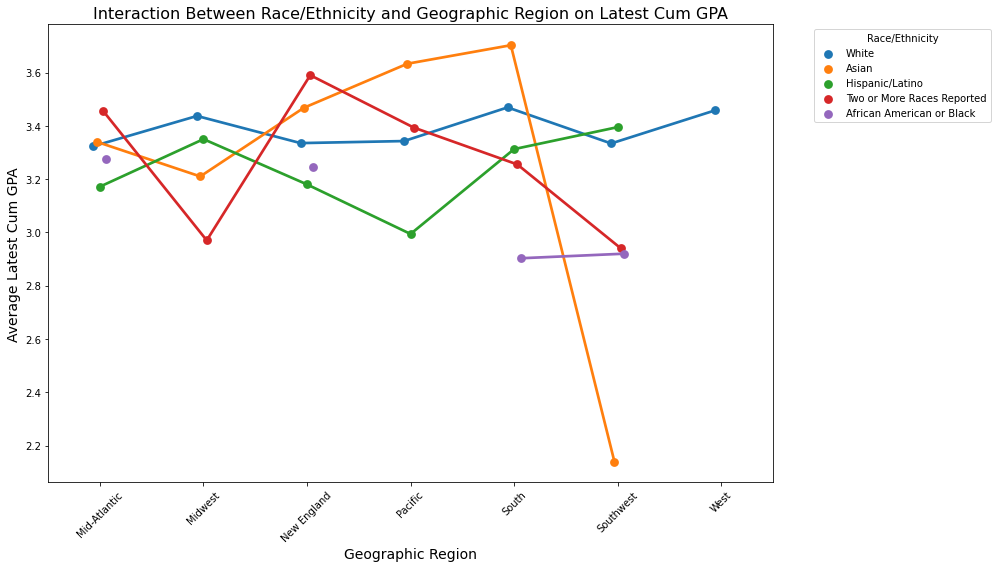

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group data by race/ethnicity and region and calculate mean GPA
interaction_data = data.groupby(['Student IPEDS Race Ethnicity', 'Student Home Admission Publication Region'])['Latest Cum GPA'].mean().reset_index()

# Plot the interaction
plt.figure(figsize=(14, 8))
sns.pointplot(
    data=interaction_data,
    x='Student Home Admission Publication Region',
    y='Latest Cum GPA',
    hue='Student IPEDS Race Ethnicity',
    dodge=True,
    markers='o',
    linestyles='-'
)
plt.title('Interaction Between Race/Ethnicity and Geographic Region on Latest Cum GPA', fontsize=16)
plt.xlabel('Geographic Region', fontsize=14)
plt.ylabel('Average Latest Cum GPA', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Race/Ethnicity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Conclusion**<br>
**1. Two-Way Interactions:**<br>
**Race/Ethnicity × Geographic Region:**<br>
Asian × Southwest: p-value = 0.006, coefficient = -1.2100.<br>
This indicates that Asian students from the Southwest have significantly lower GPAs compared to the reference group.<br>
<br>
African American or Black × South: p-value = 0.012, coefficient = -0.5162.<br>
This indicates that Asian students from the Midwest have a significantly lower College GPA compared to the reference group.<br>
<br>
Two or More Races × Midwest: p-value = 0.053, coefficient = -0.5987.<br>
This indicates that students with two or more races reported may have a lower College GPA compared to the reference group.

**<font size="3">1.2 Interaction Plot: Gender * Geographic Region</font>**

In [56]:
model_white_reference = smf.ols(
    'Q("Latest Cum GPA") ~ C(Q("Student Gender")) * C(Q("Student Home Admission Publication Region"))',
    data=data
).fit()

# Print the summary
print(model_white_reference.summary())

                             OLS Regression Results                            
Dep. Variable:     Q("Latest Cum GPA")   R-squared:                       0.079
Model:                             OLS   Adj. R-squared:                  0.052
Method:                  Least Squares   F-statistic:                     2.938
Date:                 Thu, 05 Dec 2024   Prob (F-statistic):           0.000400
Time:                         01:16:46   Log-Likelihood:                -211.08
No. Observations:                  460   AIC:                             450.2
Df Residuals:                      446   BIC:                             508.0
Df Model:                           13                                         
Covariance Type:             nonrobust                                         
                                                                                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

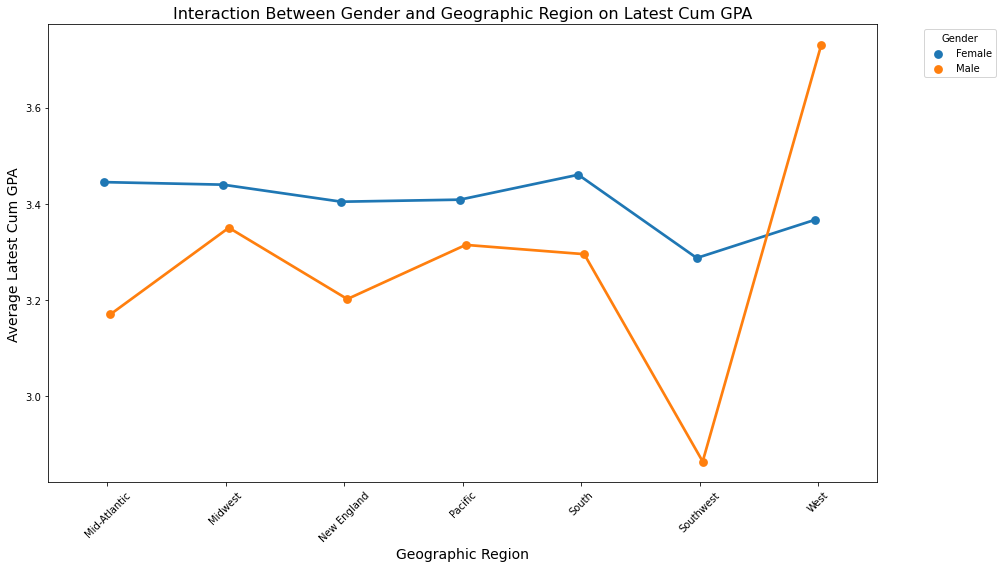

In [50]:
# Group data by gender and region and calculate mean GPA
interaction_data = data.groupby(['Student Gender', 'Student Home Admission Publication Region'])['Latest Cum GPA'].mean().reset_index()

# Plot the interaction
plt.figure(figsize=(14, 8))
sns.pointplot(
    data=interaction_data,
    x='Student Home Admission Publication Region',
    y='Latest Cum GPA',
    hue='Student Gender',
    dodge=True,
    markers='o',
    linestyles='-'
)
plt.title('Interaction Between Gender and Geographic Region on Latest Cum GPA', fontsize=16)
plt.xlabel('Geographic Region', fontsize=14)
plt.ylabel('Average Latest Cum GPA', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**<font size="3">1.3 Interaction Plot: Gender * Race/Ethnicity</font>**

In [54]:
model_white_reference = smf.ols(
    'Q("Latest Cum GPA") ~ C(Q("Student Gender")) * C(Q("Student IPEDS Race Ethnicity"))',
    data=data
).fit()

# Print the summary
print(model_white_reference.summary())

                             OLS Regression Results                            
Dep. Variable:     Q("Latest Cum GPA")   R-squared:                       0.101
Model:                             OLS   Adj. R-squared:                  0.083
Method:                  Least Squares   F-statistic:                     5.610
Date:                 Thu, 05 Dec 2024   Prob (F-statistic):           2.32e-07
Time:                         01:15:02   Log-Likelihood:                -205.52
No. Observations:                  460   AIC:                             431.0
Df Residuals:                      450   BIC:                             472.4
Df Model:                            9                                         
Covariance Type:             nonrobust                                         
                                                                                                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

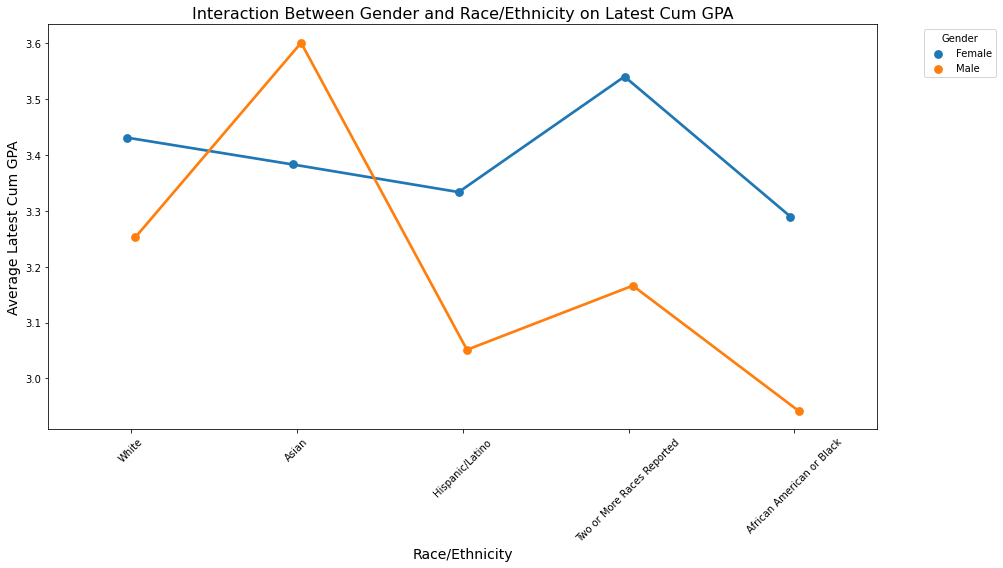

In [55]:
# Group data by gender and race/ethnicity and calculate mean GPA
interaction_data = data.groupby(['Student Gender', 'Student IPEDS Race Ethnicity'])['Latest Cum GPA'].mean().reset_index()

# Plot the interaction
plt.figure(figsize=(14, 8))
sns.pointplot(
    data=interaction_data,
    x='Student IPEDS Race Ethnicity',
    y='Latest Cum GPA',
    hue='Student Gender',
    dodge=True,
    markers='o',
    linestyles='-'
)
plt.title('Interaction Between Gender and Race/Ethnicity on Latest Cum GPA', fontsize=16)
plt.xlabel('Race/Ethnicity', fontsize=14)
plt.ylabel('Average Latest Cum GPA', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Conclusion**<br>
**1. Two-Way Interactions:**<br>
**Gender × Race/Ethnicity:**<br>
Asian × Male: p-value = 0.011, coefficient = 0.3965.<br>
This indicates that Asian male students have significantly higher GPAs compared to the reference group.

**<font size="3">1.4 Three-Way Interaction: Gender * Race/Ethnicity * Region</font>**

In [47]:
import statsmodels.formula.api as smf
#Fit the ANCOVA model with 'White' as the reference group
model_white_reference = smf.ols(
    'Q("Latest Cum GPA") ~ C(Q("Student Gender")) * C(Q("Student IPEDS Race Ethnicity")) * C(Q("Student Home Admission Publication Region"))',
    data=data
).fit()

# Print the summary
print(model_white_reference.summary())

                             OLS Regression Results                            
Dep. Variable:     Q("Latest Cum GPA")   R-squared:                       0.211
Model:                             OLS   Adj. R-squared:                  0.110
Method:                  Least Squares   F-statistic:                     2.091
Date:                 Thu, 05 Dec 2024   Prob (F-statistic):           4.12e-05
Time:                         00:35:50   Log-Likelihood:                -175.51
No. Observations:                  460   AIC:                             457.0
Df Residuals:                      407   BIC:                             676.0
Df Model:                           52                                         
Covariance Type:             nonrobust                                         
                                                                                                                                                                         coef    std err          t     

/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:675: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


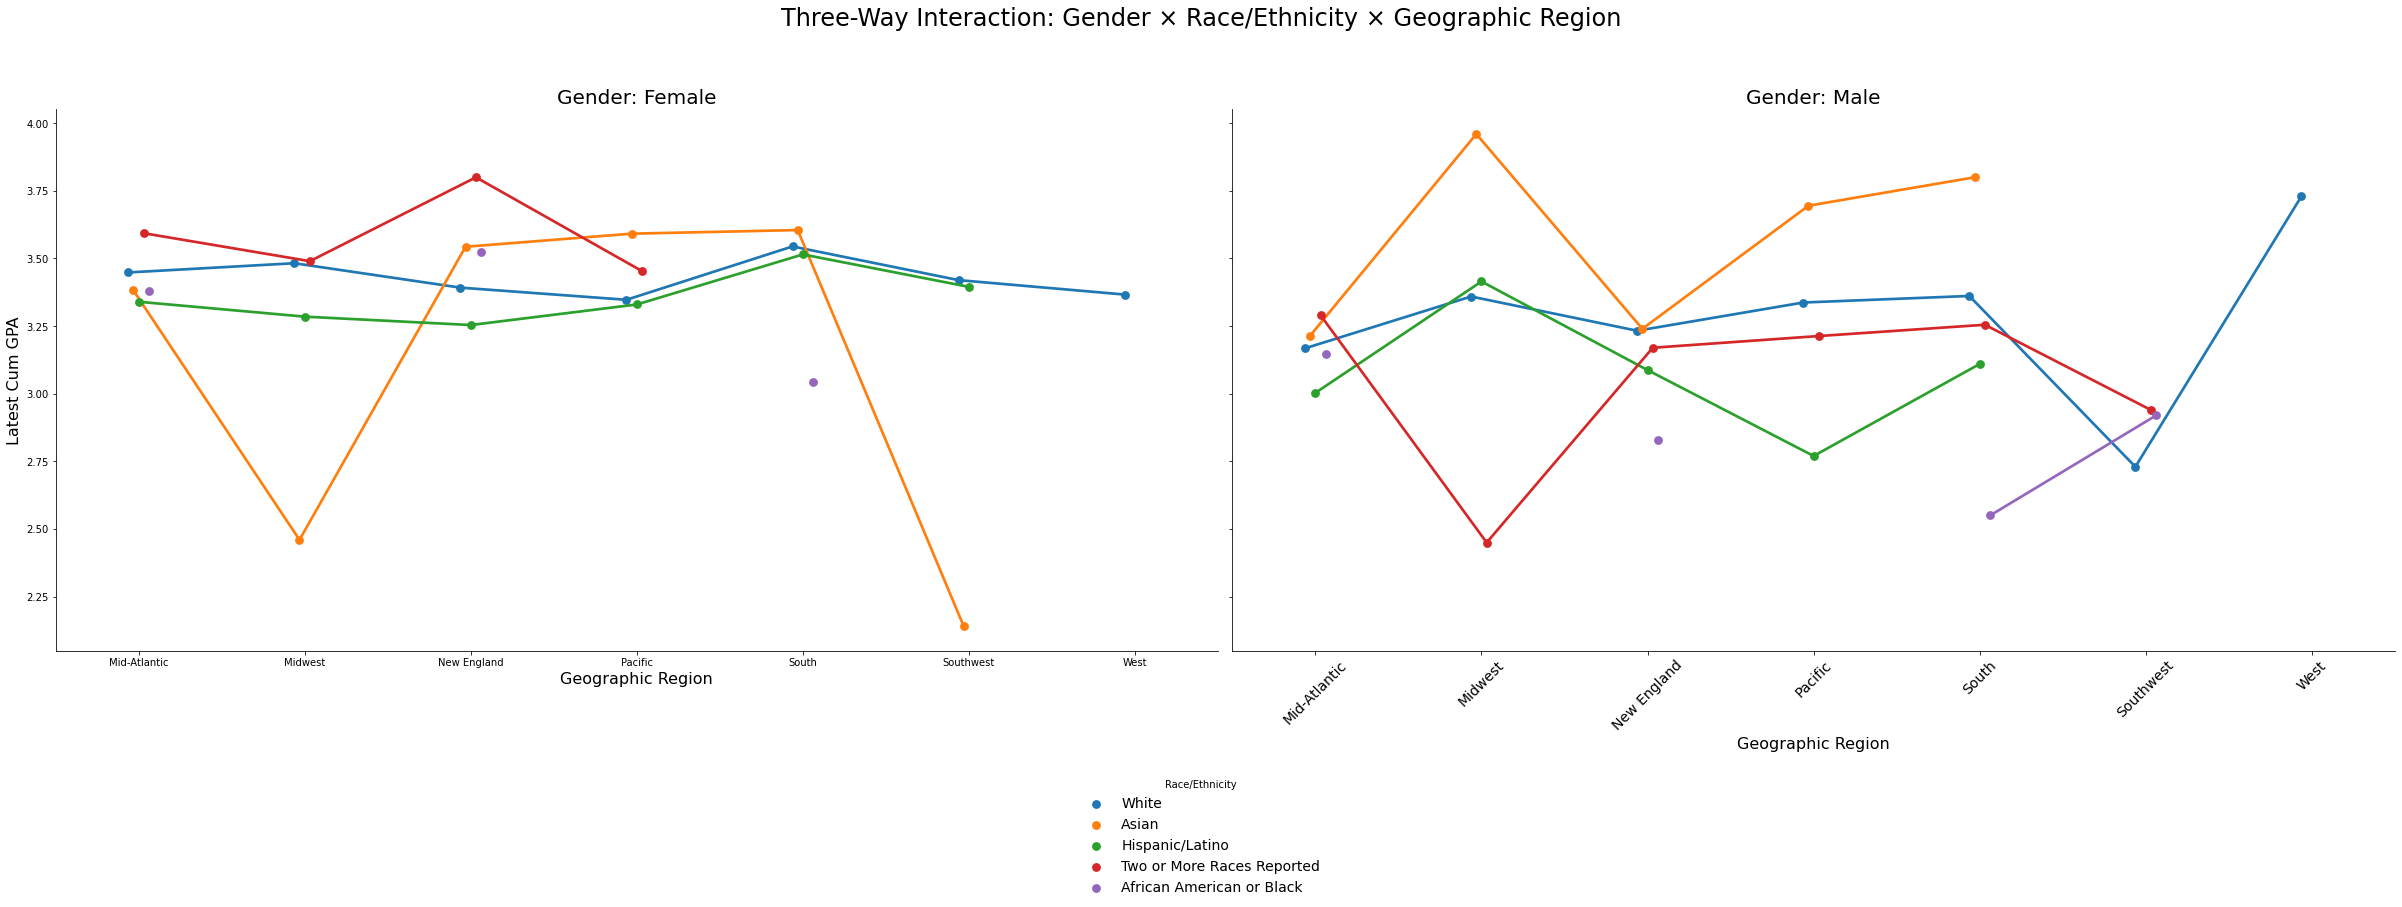

In [49]:
# Three-way interaction visualization with customization, one graph per row
import seaborn as sns
import matplotlib.pyplot as plt

# Group data by gender, race/ethnicity, and region, and calculate mean GPA
three_way_data = data.groupby(['Student Gender', 'Student IPEDS Race Ethnicity', 'Student Home Admission Publication Region'])['Latest Cum GPA'].mean().reset_index()

# Create the FacetGrid for three-way interaction, with one graph per row
g = sns.FacetGrid(
    three_way_data,
    col='Student Gender',
    height=10,  # Make each graph taller
    aspect=1.5,  # Adjust the aspect ratio
    sharey=True
)

# Map the pointplot onto the FacetGrid
g.map(
    sns.pointplot,
    'Student Home Admission Publication Region',
    'Latest Cum GPA',
    'Student IPEDS Race Ethnicity',
    dodge=True,
    markers='o',
    linestyles='-', 
    palette='tab10'  # Use a different color palette
)

# Add a legend and adjust labels
g.add_legend(
    title='Race/Ethnicity',
    fontsize=14,
    title_fontsize=16,
    bbox_to_anchor=(0.5, -0.2),  # Move legend downward
    loc='lower center'
)
g.set_axis_labels('Geographic Region', 'Latest Cum GPA', fontsize=16)
g.set_titles(template='Gender: {col_name}', size=20)  # Adjust title size for each graph
g.fig.suptitle('Three-Way Interaction: Gender × Race/Ethnicity × Geographic Region', y=1.05, fontsize=24)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)

# Adjust layout to ensure readability
plt.tight_layout()
plt.show()


**Conclusion:**
**3. Three-Way Interactions:**<br>
Male × Asian × Midwest: p-value = 0.017, coefficient = 1.5093<br>
This suggests that male Asian students from the Midwest perform significantly better than expected compared to the reference group<br>

Final Results:
Female × Midwest × Asian:
Coefficient = 
2.4600
2.4600
SE = 
0.454
0.454
t-value = 
5.42
5.42
p-value < 0.001
Female × Southwest × Asian:
Coefficient = 
2.1400
2.1400
SE = 
0.487
0.487
t-value = 
4.39
4.39
p-value < 0.001